In [1]:
#!pip install -q segmentation-models-pytorch==0.3.5 torchinfo
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
#import segmentation_models_pytorch as smp
from PIL import Image
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split


In [2]:
DATA_DIR   = Path('/kaggle/input/fetus-segmentation')
IMG_DIR    = os.path.join(DATA_DIR ,'preprocessed_images')
MASK_DIR   = os.path.join(DATA_DIR ,'segmentations')

In [3]:

# 2) Gather and filter filenames
all_imgs = [f for f in os.listdir(IMG_DIR) if f.endswith('.png')]
valid_imgs = [
    img for img in all_imgs
    if os.path.exists(os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png"))
]

#print(f"Found {len(valid_imgs)} image–mask pairs.")

# 3) Split into train / test (80/20)
train_files, test_files = train_test_split(
    valid_imgs,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

#print(f"Train on {len(train_files)} images, test on {len(test_files)} images.")

# 4) Build full paths lists
train_imgs  = [os.path.join(IMG_DIR,  img) for img in train_files]
train_masks = [os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png")
               for img in train_files]

test_imgs   = [os.path.join(IMG_DIR,  img) for img in test_files]
test_masks  = [os.path.join(MASK_DIR, f"seg_{os.path.splitext(img)[0]}.png")
               for img in test_files]



In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

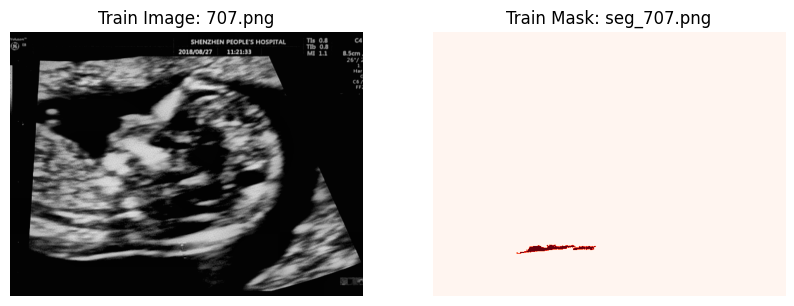

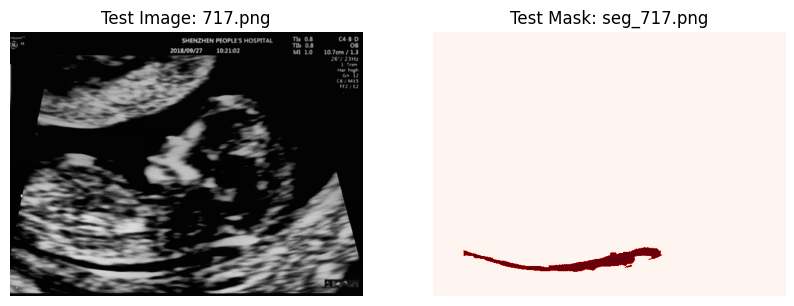

In [5]:
# Convert to lists if they’re Paths
train_files = [f.name if hasattr(f, 'name') else f for f in train_files]
test_files  = [f.name if hasattr(f, 'name') else f for f in test_files]

# Choose random samples
train_sample = random.choice(train_files)
test_sample  = random.choice(test_files)

# Paths
train_img  = os.path.join(IMG_DIR, train_sample)
train_mask = os.path.join(MASK_DIR, f"seg_{os.path.splitext(train_sample)[0]}.png")
test_img   = os.path.join(IMG_DIR, test_sample)
test_mask  = os.path.join(MASK_DIR,  f"seg_{os.path.splitext(test_sample)[0]}.png")

def plot_pair(img_path, mask_path, title):
    img  = mpimg.imread(img_path)
    mask = mpimg.imread(mask_path)
    if mask.max() <= 1.0:
        mask = mask * 255

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img, cmap='gray')
    ax1.set_title(f"{title} Image: {os.path.basename(img_path)}")
    ax1.axis('off')

    ax2.imshow(mask, cmap='Reds')
    ax2.set_title(f"{title} Mask: {os.path.basename(mask_path)}")
    ax2.axis('off')
    plt.show()

# Display
plot_pair(train_img, train_mask, 'Train')
plot_pair(test_img, test_mask,   'Test')

In [6]:
print(f"Number of train images: {len(train_imgs)}")
print(f"Number of train masks:  {len(train_masks)}")

print(f"Number of test images:  {len(test_imgs)}")
print(f"Number of test masks:   {len(test_masks)}")

Number of train images: 888
Number of train masks:  888
Number of test images:  222
Number of test masks:   222


In [10]:
from collections import Counter
import cv2

In [11]:

def get_shapes(paths):
    shapes = [cv2.imread(p, cv2.IMREAD_UNCHANGED).shape[:2] for p in paths]
    # shape[:2] is (height, width)
    return Counter(shapes)

# your four lists:
#   train_imgs, train_masks, test_imgs, test_masks

print(f"Number of train images: {len(train_imgs)}")
print(f"Train image dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(train_imgs).items():
    print(f"  {h}×{w}: {cnt}")

print(f"\nNumber of train masks: {len(train_masks)}")
print(f"Train mask dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(train_masks).items():
    print(f"  {h}×{w}: {cnt}")

print(f"\nNumber of test images: {len(test_imgs)}")
print(f"Test image dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(test_imgs).items():
    print(f"  {h}×{w}: {cnt}")

print(f"\nNumber of test masks: {len(test_masks)}")
print(f"Test mask dimensions (H×W) frequency:")
for (h, w), cnt in get_shapes(test_masks).items():
    print(f"  {h}×{w}: {cnt}")

Number of train images: 888
Train image dimensions (H×W) frequency:
  450×600: 888

Number of train masks: 888
Train mask dimensions (H×W) frequency:
  450×600: 888

Number of test images: 222
Test image dimensions (H×W) frequency:
  450×600: 222

Number of test masks: 222
Test mask dimensions (H×W) frequency:
  450×600: 222


In [12]:

class FetusSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        assert len(image_paths) == len(mask_paths), "Images and masks counts must match"
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transforms  = transforms or T.Compose([
            T.Resize((256,256)),      # optional: down/up-sample
            T.ToTensor(),             # [0–255] → [0–1], shape [C,H,W]
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load grayscale image & mask
        img  = Image.open(self.image_paths[idx]).convert('L')
        msk  = Image.open(self.mask_paths[idx]).convert('L')
        
        # Apply identical transforms
        img_t = self.transforms(img)
        msk_t = self.transforms(msk)
        
        # Optionally: binarize mask (if not already 0/1)
        msk_t = (msk_t > 0.5).float()
        
        return img_t, msk_t

# --- Transforms (you can add normalization or augmentation here) ---
transforms = T.Compose([
    T.Resize((450,600)),   # keep original size
    T.ToTensor(),          # → [0,1]
])

# 1) Create datasets
train_ds = FetusSegDataset(train_imgs,  train_masks, transforms=transforms)
test_ds  = FetusSegDataset(test_imgs,   test_masks,  transforms=transforms)

# 2) Create loaders
batch_size = 8
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 3) Quick sanity‐check
# Pull one batch and inspect shapes
imgs, masks = next(iter(train_loader))
print("Images batch:", imgs.shape)   # e.g. [8, 1, 450, 600]
print("Masks batch: ", masks.shape)  # e.g. [8, 1, 450, 600]

Images batch: torch.Size([8, 1, 450, 600])
Masks batch:  torch.Size([8, 1, 450, 600])


In [13]:
# 1) Set a batch size
batch_size = 8

# 2) Create the loaders
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,      # shuffle for training
    num_workers=2,     # adjust to your machine
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,     # no shuffle for validation
    num_workers=2,
    pin_memory=True
)

# 3) Sanity check
imgs, masks = next(iter(train_loader))
print("Train batch  images:", imgs.shape)   # [batch, 1, H, W]
print("Train batch  masks: ", masks.shape)  # [batch, 1, H, W]

NameError: name 'val_ds' is not defined